![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [172]:
# Import necessary libraries
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Load the dataset
df= pd.read_csv("cc_approvals.data", header=None) 
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [173]:
#examining dataframe
print(df.info())
#Checing for null values
print(df.isna().sum())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB
None
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
dtype: int64
(690, 14)


In [174]:
#Creating new column names
new_column_names = [f'col_{i}' for i in range(14)]
#Changing the column names
df.columns = new_column_names
#Examining the result
print(df.head())

  col_0  col_1  col_2 col_3 col_4 col_5 col_6  col_7 col_8 col_9  col_10  \
0     b  30.83  0.000     u     g     w     v   1.25     t     t       1   
1     a  58.67  4.460     u     g     q     h   3.04     t     t       6   
2     a  24.50  0.500     u     g     q     h   1.50     t     f       0   
3     b  27.83  1.540     u     g     w     v   3.75     t     t       5   
4     b  20.17  5.625     u     g     w     v   1.71     t     f       0   

  col_11  col_12 col_13  
0      g       0      +  
1      g     560      +  
2      g     824      +  
3      g       3      +  
4      s       0      +  


?        12
22.67     9
20.42     7
18.83     6
24.50     6
         ..
48.25     1
28.33     1
18.75     1
18.50     1
36.42     1
Name: col_1, Length: 350, dtype: int64


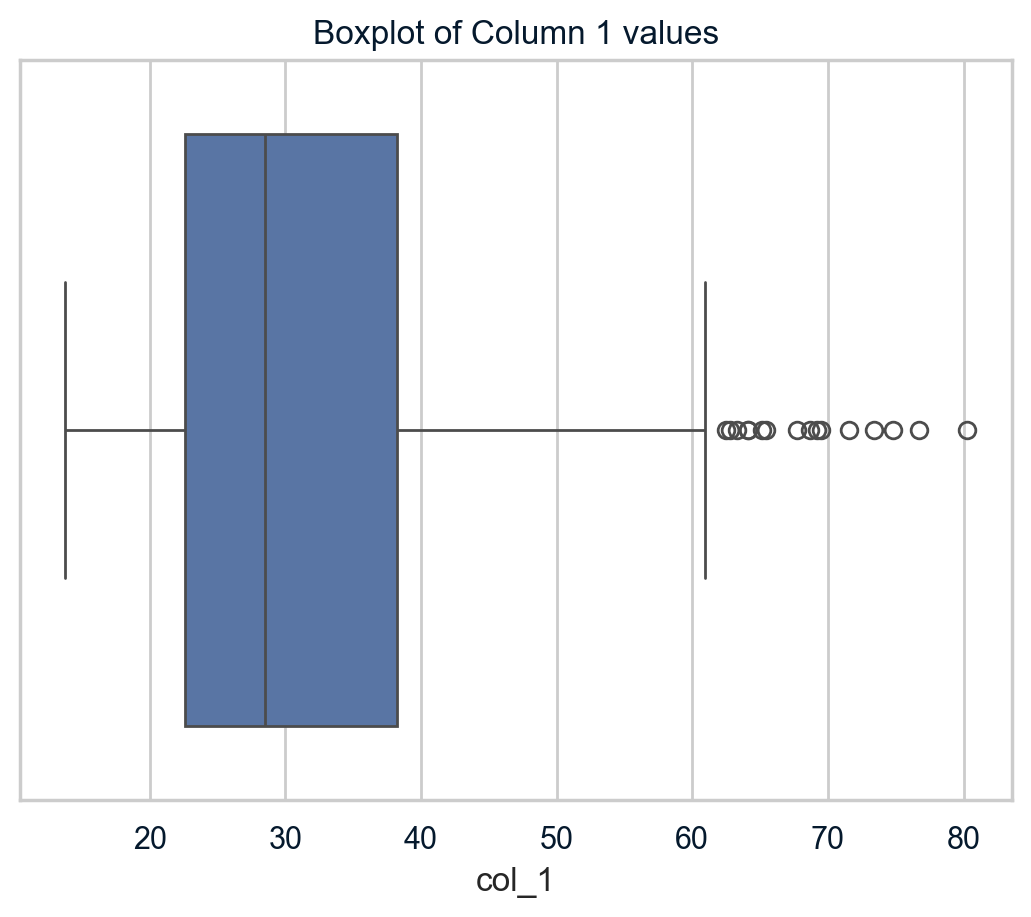

In [175]:
#Examining the values of col_1 since it has numbers but the datatype shows object
print(df['col_1'].value_counts())
#Replacing the ? values with np.NaN
df['col_1'] = df['col_1'].replace('?', np.NaN)
#converting the column to float64 datatype
df['col_1'] = df['col_1'].astype('float64')
#Looking at the distribution of values to check for outliers
sns.boxplot(x='col_1', data=df)
plt.title('Boxplot of Column 1 values')
plt.show()
#Calculating the median since there are a significant number of outliers
col1_median = df['col_1'].median()
#Filling the np.NaN values with the median
df['col_1'] = df['col_1'].fillna(col1_median)

In [176]:
#Creating the feature and target variables
X=df.drop('col_13', axis=1)
y=df['col_13']
print(X.columns)

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9', 'col_10', 'col_11', 'col_12'],
      dtype='object')


In [177]:
#Convering categorical variables to numerical using one-hot encoding
#Selecting object columns
categorical_cols = X.select_dtypes(include=['object'])
#Applying the one-hot encoding
categorical_cols = pd.get_dummies(categorical_cols, drop_first=True)
#Examining the results
print(categorical_cols.head())

   col_0_a  col_0_b  col_3_l  col_3_u  col_3_y  col_4_g  col_4_gg  col_4_p  \
0        0        1        0        1        0        1         0        0   
1        1        0        0        1        0        1         0        0   
2        1        0        0        1        0        1         0        0   
3        0        1        0        1        0        1         0        0   
4        0        1        0        1        0        1         0        0   

   col_5_aa  col_5_c  col_5_cc  col_5_d  col_5_e  col_5_ff  col_5_i  col_5_j  \
0         0        0         0        0        0         0        0        0   
1         0        0         0        0        0         0        0        0   
2         0        0         0        0        0         0        0        0   
3         0        0         0        0        0         0        0        0   
4         0        0         0        0        0         0        0        0   

   col_5_k  col_5_m  col_5_q  col_5_r  col_5_w  co

In [178]:
#Selecting the numerical columns
numerical_cols = X.select_dtypes(include=['int64','float64'])
#Concatenating the numerical and categorical_cols
X = pd.concat([numerical_cols, categorical_cols], axis=1)
#Examining the results
print(X.head())

   col_1  col_2  col_7  col_10  col_12  col_0_a  col_0_b  col_3_l  col_3_u  \
0  30.83  0.000   1.25       1       0        0        1        0        1   
1  58.67  4.460   3.04       6     560        1        0        0        1   
2  24.50  0.500   1.50       0     824        1        0        0        1   
3  27.83  1.540   3.75       5       3        0        1        0        1   
4  20.17  5.625   1.71       0       0        0        1        0        1   

   col_3_y  col_4_g  col_4_gg  col_4_p  col_5_aa  col_5_c  col_5_cc  col_5_d  \
0        0        1         0        0         0        0         0        0   
1        0        1         0        0         0        0         0        0   
2        0        1         0        0         0        0         0        0   
3        0        1         0        0         0        0         0        0   
4        0        1         0        0         0        0         0        0   

   col_5_e  col_5_ff  col_5_i  col_5_j  col_5_k  c

In [179]:
#Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
#Since we changed the ? values in col_1 to np.NaN, we will have to impute the values again after splitting
median_value = X_train['col_1'].median()
print(median_value)
X_train_imputed = X_train.fillna(median_value)
X_test_imputed = X_test.fillna(median_value)

28.46


In [180]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
lr_grid_search = GridSearchCV(lr_model, lr_param_grid,cv=5, scoring='accuracy')
lr_grid_search.fit(X_train_imputed, y_train)
y_pred = lr_grid_search.predict(X_test_imputed)
#Calculating the training and testing accuracy
from sklearn.metrics import accuracy_score, classification_report
lr_model_acc = round(accuracy_score(y_test, y_pred),2)
print('Accuracy: ',lr_model_acc)
print('Best Parameters: ',lr_grid_search.best_params_)
print('Best Score: ',round(lr_grid_search.best_score_,2))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy:  0.86
Best Parameters:  {'C': 10, 'penalty': 'l2'}
Best Score:  0.86
Confusion Matrix:
 [[53  8]
 [12 65]]
Classification Report:
               precision    recall  f1-score   support

           +       0.82      0.87      0.84        61
           -       0.89      0.84      0.87        77

    accuracy                           0.86       138
   macro avg       0.85      0.86      0.85       138
weighted avg       0.86      0.86      0.86       138



In [181]:
from sklearn.neighbors import KNeighborsClassifier
# Initializing and fitting the KNN model
knn_model = KNeighborsClassifier(n_neighbors = 45)
knn_param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train_imputed, y_train)
#Predicting on the test set
y_pred = knn_grid_search.predict(X_test_imputed)
#Calculating the accuracy
knn_model_acc = round(accuracy_score(y_test, y_pred),2)
print('Accuracy: ',knn_model_acc)
print('Best Parameters: ',knn_grid_search.best_params_)
print('Best Score: ',round(knn_grid_search.best_score_,2))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy:  0.74
Best Parameters:  {'n_neighbors': 9, 'weights': 'distance'}
Best Score:  0.71
Confusion Matrix:
 [[34 27]
 [ 9 68]]
Classification Report:
               precision    recall  f1-score   support

           +       0.79      0.56      0.65        61
           -       0.72      0.88      0.79        77

    accuracy                           0.74       138
   macro avg       0.75      0.72      0.72       138
weighted avg       0.75      0.74      0.73       138



In [182]:
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_param_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_leaf': [1, 2, 4]}
dtc_grid_search = GridSearchCV(dtc_model, dtc_param_grid, cv=5, scoring='accuracy')
dtc_grid_search.fit(X_train_imputed, y_train)
y_pred = dtc_grid_search.predict(X_test_imputed)
dtc_model_acc = round(accuracy_score(y_test, y_pred),2)
print('Accuracy: ',dtc_model_acc)
print('Best Parameters: ',dtc_grid_search.best_params_)
print('Best Score: ',round(dtc_grid_search.best_score_,2))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy:  0.85
Best Parameters:  {'max_depth': 3, 'min_samples_leaf': 4}
Best Score:  0.84
Confusion Matrix:
 [[57  4]
 [17 60]]
Classification Report:
               precision    recall  f1-score   support

           +       0.77      0.93      0.84        61
           -       0.94      0.78      0.85        77

    accuracy                           0.85       138
   macro avg       0.85      0.86      0.85       138
weighted avg       0.86      0.85      0.85       138



In [183]:
# Get the results for each model
lr_best_score = lr_grid_search.best_score_
dtc_best_score = dtc_grid_search.best_score_
knn_best_score = knn_grid_search.best_score_

# Print the best scores
print(f"Logistic Regression Accuracy: {lr_best_score:.4f}")
print(f"Decision Tree Accuracy: {dt_best_score:.4f}")
print(f"KNN Accuracy: {knn_best_score:.4f}")

# Find the best overall model
best_scores = {
    'Logistic Regression': lr_best_score,
    'Decision Tree': dtc_best_score,
    'KNeighborsClassifier': knn_best_score
}

best_model_name = max(best_scores, key=best_scores.get)
best_score = round(best_scores[best_model_name],2)
print('The best score is:',best_score)
print(f"The best performing model is: {best_model_name} with an accuracy of {best_scores[best_model_name]:.2f}")



Logistic Regression Accuracy: 0.8624
Decision Tree Accuracy: 0.8443
KNN Accuracy: 0.7102
The best score is: 0.86
The best performing model is: Logistic Regression with an accuracy of 0.86
